In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.exceptions import ConvergenceWarning
import warnings
from multilayer_perceptron import MLP, train, get_weights
from neural_interaction_detection import get_interactions
import itertools
from utils import preprocess_data, get_pairwise_auc, get_anyorder_R_precision, set_seed, print_rankings
from sklearn.utils import shuffle
from tqdm import trange 

## Experiment 1

## Hypothesis

### Additive Case:  
**$Y = X_1 + X_2$**

In an additive function, each feature contributes independently to the target.  
No synergy exists between the features; hence, any “interaction” detected by the network should be very weak (close to zero).


### Multiplicative Case:  
**$Y = X_1 \times X_2$**

In a multiplicative function, the output depends on the joint contribution of both features.  
The network learns weights that capture this dependency, so the method detects a strong interaction between $X_1$ and $X_2$.


In [2]:
def additive_func(X):
    Y = X[:, 0] + X[:, 1]
    return Y, [{0}, {1}]

def multiplicative_func(X):
    Y = X[:, 0] * X[:, 1]
    return Y, [{0, 1}]

In [3]:
def run_experiment(synthetic_func, title, use_main_effect_nets=True):
    print(f"\n--- {title} ---")
    set_seed(42)
    num_samples = 30000
    num_features = 2  
    X = np.random.normal(0, 1, size=(num_samples, num_features))
    Y, ground_truth = synthetic_func(X)

    data_loaders = preprocess_data(X, Y, valid_size=10000, test_size=10000, std_scale=True, get_torch_loaders=True)

    device = torch.device("cuda")
    model = MLP(num_features, [64, 32], use_main_effect_nets=use_main_effect_nets).to(device)

    model, loss = train(model, data_loaders, device=device, learning_rate=0.01, l1_const=1e-4, verbose=True)

    model_weights = get_weights(model)
    interactions = get_interactions(model_weights, pairwise=True)
    
    print("Top Detected Interactions:")
    for inter, strength in interactions[:5]:
        print(f"  {inter} -> {strength:.4f}")
    
    for inter, strength in interactions:
        if set(inter) == {0, 1}:
            return strength
    return 0.0

In [4]:
strength_add = run_experiment(additive_func, "Additive: Y = X1 + X2")


--- Additive: Y = X1 + X2 ---
starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.0332, val loss: 0.0002
[epoch 3, total 100] train loss: 0.0001, val loss: 0.0001
[epoch 5, total 100] train loss: 0.0001, val loss: 0.0001
[epoch 7, total 100] train loss: 0.0001, val loss: 0.0002
[epoch 9, total 100] train loss: 0.0005, val loss: 0.0002
[epoch 11, total 100] train loss: 0.0003, val loss: 0.0002
[epoch 13, total 100] train loss: 0.0002, val loss: 0.0001
[epoch 15, total 100] train loss: 0.0004, val loss: 0.0001
[epoch 17, total 100] train loss: 0.0001, val loss: 0.0001
[epoch 19, total 100] train loss: 0.0002, val loss: 0.0004
[epoch 21, total 100] train loss: 0.0001, val loss: 0.0002
[epoch 23, total 100] train loss: 0.0000, val loss: 0.0001
[epoch 25, total 100] train loss: 0.0001, val loss: 0.0001
[epoch 27, total 100] train loss: 0.0001, val loss: 0.0002
early stopping!
Finished Training. Test loss:  2.0475843484746292e-05
Top Detected Interactions:
  (0, 1) -

In [5]:
strength_mult = run_experiment(multiplicative_func, "Multiplicative: Y = X1 * X2")


--- Multiplicative: Y = X1 * X2 ---
starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.1190, val loss: 0.0092
[epoch 3, total 100] train loss: 0.0041, val loss: 0.0041
[epoch 5, total 100] train loss: 0.0025, val loss: 0.0018
[epoch 7, total 100] train loss: 0.0039, val loss: 0.0016
[epoch 9, total 100] train loss: 0.0026, val loss: 0.0050
[epoch 11, total 100] train loss: 0.0021, val loss: 0.0022
[epoch 13, total 100] train loss: 0.0025, val loss: 0.0032
[epoch 15, total 100] train loss: 0.0015, val loss: 0.0006
[epoch 17, total 100] train loss: 0.0023, val loss: 0.0014
[epoch 19, total 100] train loss: 0.0022, val loss: 0.0019
[epoch 21, total 100] train loss: 0.0022, val loss: 0.0025
early stopping!
Finished Training. Test loss:  0.001471778261475265
Top Detected Interactions:
  (0, 1) -> 7.3664


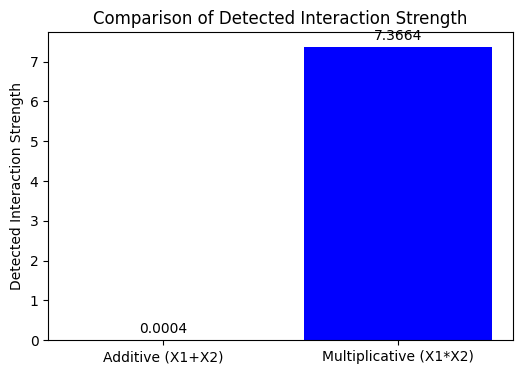

In [7]:
labels = ['Additive (X1+X2)', 'Multiplicative (X1*X2)']
strengths = [strength_add, strength_mult]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, strengths, color=['gray', 'blue'])
plt.ylabel("Detected Interaction Strength")
plt.title("Comparison of Detected Interaction Strength")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.show()

## Experiment 2

Will run on one synthetic dataset to check the algo

In [8]:
use_main_effect_nets = True 
num_samples = 30000
num_features = 10

In [9]:
def synth_func(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()
    interaction1 = np.exp(np.abs(X1-X2))                         
    interaction2 = np.abs(X2*X3)  
    interaction3 = -1*(X3**2)**np.abs(X4) 
    interaction4 = (X1*X4)**2
    interaction5 = np.log(X4**2 + X5**2 + X7**2 + X8**2)
    main_effects = X9 + 1/(1 + X10**2)
    Y = interaction1 + interaction2 + interaction3 + interaction4 + interaction5 + main_effects
    ground_truth = [{1,2}, {2,3}, {3,4}, {1,4}, {4,5,7,8}]
    
    return Y, ground_truth


In [10]:
set_seed(42)
X = np.random.uniform(low=-1, high=1, size=(num_samples,num_features))
Y, ground_truth = synth_func(X)
data_loaders = preprocess_data(X, Y, valid_size=10000, test_size=10000, std_scale=True, get_torch_loaders=True)

In [11]:
device = torch.device("cuda")
model = MLP(num_features, [140, 100, 60, 20], use_main_effect_nets=use_main_effect_nets).to(device)

In [12]:
model, mlp_loss = train(model, data_loaders, device=device, learning_rate=1e-2, l1_const = 5e-5, verbose=True)

starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.2307, val loss: 0.0392
[epoch 3, total 100] train loss: 0.0318, val loss: 0.0310
[epoch 5, total 100] train loss: 0.0235, val loss: 0.0343
[epoch 7, total 100] train loss: 0.0173, val loss: 0.0144
[epoch 9, total 100] train loss: 0.0136, val loss: 0.0152
[epoch 11, total 100] train loss: 0.0106, val loss: 0.0093
[epoch 13, total 100] train loss: 0.0091, val loss: 0.0087
[epoch 15, total 100] train loss: 0.0095, val loss: 0.0081
[epoch 17, total 100] train loss: 0.0091, val loss: 0.0084
[epoch 19, total 100] train loss: 0.0079, val loss: 0.0073
[epoch 21, total 100] train loss: 0.0088, val loss: 0.0064
early stopping!
Finished Training. Test loss:  0.006006360519677401


In [13]:
model_weights = get_weights(model)

In [14]:
anyorder_interactions = get_interactions(model_weights, one_indexed=True)
pairwise_interactions = get_interactions(model_weights, pairwise=True, one_indexed=True)
print_rankings(pairwise_interactions, anyorder_interactions, top_k=10, spacing=14)

Pairwise interactions              Arbitrary-order interactions
(1, 2)        8.5205                      (1, 2)        7.6003        
(1, 4)        2.7423                      (1, 4)        1.6097        
(7, 8)        2.4615                      (2, 3)        1.5943        
(5, 7)        2.2680                      (7, 8)        1.3218        
(5, 8)        2.1044                      (5, 8)        1.2205        
(4, 7)        2.0595                      (4, 5)        1.0210        
(2, 3)        2.0509                      (5, 7)        0.8530        
(4, 8)        1.9352                      (1, 2, 4)     0.8384        
(4, 5)        1.8666                      (4, 7)        0.7218        
(2, 4)        1.5391                      (4, 8)        0.6983        


In [15]:
auc = get_pairwise_auc(pairwise_interactions, ground_truth)
r_prec = get_anyorder_R_precision(anyorder_interactions, ground_truth)
print("Pairwise AUC", auc, ", Any-order R-Precision", r_prec)

Pairwise AUC 0.9971428571428571 , Any-order R-Precision 0.8


High Pairwise AUC and R_Precision tell NID was able to determine the interaction

## Experiment 3

Will run algo on 10 differenct synthetic datasets

In [49]:
# Helper functions to avoid invalid values in sqrt and log computations
def sqrt(x):
    return np.sqrt(np.maximum(x, 0))

def log(x):
    return np.log(np.maximum(x, 1e-10))

def F1(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.exp(np.abs(X1-X2))
    interaction2 = np.abs(X2*X3)
    interaction3 = -1*((X3**2)**(np.abs(X4)))
    main_effects = X9 + 1/(1 + X10**2)

    Y =              interaction1 + interaction2 + interaction3   + main_effects
    ground_truth = [     {1,2},        {2,3},         {3,4}           ]
    return Y, ground_truth

def F2(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = (np.pi**(X1*X2))*(sqrt(2*np.abs(X3)))
    interaction2 = -1*(np.arcsin(0.5*X4))
    interaction3 = log(np.abs(X3+X5)+1)
    interaction4 = -1*((X9)/(1+np.abs(X10))*(sqrt(X7/(1+np.abs(X8)))))
    interaction5 = -1*X2*X7

    Y =              interaction1 + interaction3 + interaction4 + interaction5 + interaction2
    ground_truth = [     {1,2, 3},        {3,5},         {7,8,9,10},        {2,7}     ]

    return Y, ground_truth

def F3(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.exp(np.abs(X1-X2))
    interaction2 = np.abs(X2*X3)
    interaction3 = -1*((X3**2)**(np.abs(X4)))
    interaction4 = np.log(X4**2 + X5**2 + X7**2 + X8**2)
    main_effects = X9 + 1/(1 + X10**2)

    Y =              interaction1 + interaction2 + interaction3 + interaction4  + main_effects
    ground_truth = [     {1,2},        {2,3},         {3,4},        {4,5,7,8}     ]

    return Y, ground_truth

def F4(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.exp(np.abs(X1-X2))
    interaction2 = np.abs(X2*X3)
    interaction3 = -1*(X3**2)**np.abs(X4)
    interaction4 = (X1*X4)**2
    interaction5 = log(X4**2 + X5**2 + X7**2 + X8**2)
    main_effects = X9 + 1/(1 + X10**2)

    Y =              interaction1 + interaction2 + interaction3 + interaction4 + interaction5 + main_effects
    ground_truth = [     {1,2},        {2,3},         {3,4},         {1,4},        {4,5,7,8}     ]

    return Y, ground_truth

def F5(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = 1 / (1 + X1**2 + X2**2 + X3**2)
    interaction2 = sqrt(np.exp(X4 + X5))
    interaction3 = np.abs(X6 + X7)
    interaction4 = X8 * X9 * X10

    Y = interaction1 + interaction2 + interaction4 + interaction3
    ground_truth = [{1,2,3}, {4,5}, {8,9,10}]
    
    return Y, ground_truth

def F6(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.exp(np.abs(X1 * X2) + 1)
    interaction2 = -1*(np.exp(np.abs(X3 + X4) + 1))
    interaction3 = np.cos(X5 + X6 - X8)
    interaction4 = sqrt(X8**2 + X9**2 + X10**2)

    Y = interaction1 + interaction2 + interaction3 + interaction4
    ground_truth = [{1,2}, {3,4}, {5,6,8}, {8,9,10}]
    
    return Y, ground_truth

def F7(X):

    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = (np.arctan(X1) + np.arctan(X2))**2
    interaction2 = np.maximum(X3 * X4 + X6, 0)
    interaction3 = -1 / (1 + (X4 * X5 * X6 * X7 * X8)**2)
    interaction4 = (np.abs(X7) / (1 + np.abs(X9)))**5
    main_effects = X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10

    Y = interaction1 + interaction2 + interaction3 + interaction4 + main_effects
    ground_truth = [{1,2}, {3,4,6}, {4,5,6,7,8}, {7,9}]
    
    return Y, ground_truth

def F8(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = X1 * X2
    interaction2 = 2**(X3 + X5 + X6)
    interaction3 = 2**(X3 + X4 + X5 + X7)
    interaction4 = np.sin(X7 * np.sin(X8 + X9))
    interaction5 = np.arccos(0.9 * X10)

    Y = interaction1 + interaction2 + interaction3 + interaction4 + interaction5
    ground_truth = [{1,2}, {3,5,6}, {3,4,5,7}, {7,8,9}]
    
    return Y, ground_truth

def F9(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.tanh(X1 * X2 + X3 * X4) * sqrt(np.abs(X5))
    interaction2 = np.exp(X5 + X6)
    interaction3 = log((X6 * X7 * X8)**2 + 1)
    interaction4 = X9 * X10
    main_effects = 1 / (1 + np.abs(X10))

    Y = interaction1 + interaction2 + interaction3 + interaction4 + main_effects
    ground_truth = [{1,2,3,4,5}, {5,6}, {6,7,8}, {9,10}]
    
    return Y, ground_truth

def F10(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.sinh(X1 + X2)
    interaction2 = np.arccos(np.tanh(X3 + X5 + X7))
    interaction3 = np.cos(X4 + X5)
    interaction4 = 1 / np.cos(X7 * X9)

    Y = interaction1 + interaction2 + interaction3 + interaction4
    ground_truth = [{1,2}, {3,5,7}, {4,5}, {7,9}]
    
    return Y, ground_truth

In [17]:
use_main_effect_nets = True
num_samples = 30000
valid_size = 10000
test_size = 10000
device = torch.device("cuda")
hidden_layers = [140, 100, 60, 20]
l1_const = 5e-5
learning_rate = 1e-2

In [18]:
function_list = [F1, F2, F3, F4, F5, F6, F7,F8,F9,F10]
function_names = ["F1", "F2", "F3", "F4", "F5", "F6","F7", "F8", "F9", "F10"]

In [19]:
set_seed(42)  

In [20]:
results = []
for func, func_name in zip(function_list, function_names):
    print(f"\n==== Running {func_name} ====")
    X = np.random.uniform(low=-1, high=1, size=(num_samples, 10))
    Y, ground_truth = func(X)

    data_loaders = preprocess_data(X, Y, valid_size=valid_size, test_size=test_size, std_scale=True, get_torch_loaders=True)

    model = MLP(num_features=10, hidden_units=hidden_layers, use_main_effect_nets=use_main_effect_nets).to(device)
    model, mlp_loss = train(model, data_loaders, device=device, learning_rate=learning_rate, l1_const=l1_const, verbose=True)

    w = get_weights(model)
    pairwise_inters = get_interactions(w, pairwise=True, one_indexed=True)
    
    results.append((func_name, pairwise_inters, ground_truth))
    
    anyorder_inters = get_interactions(w, pairwise=False, one_indexed=True)
    if ground_truth:
        auc = get_pairwise_auc(pairwise_inters, ground_truth)
        r_prec = get_anyorder_R_precision(anyorder_inters, ground_truth)
        print("Pairwise AUC:", auc, ", Any-order R-Precision:", r_prec)


==== Running F1 ====
starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.1719, val loss: 0.0204
[epoch 3, total 100] train loss: 0.0172, val loss: 0.0125
[epoch 5, total 100] train loss: 0.0092, val loss: 0.0081
[epoch 7, total 100] train loss: 0.0110, val loss: 0.0098
[epoch 9, total 100] train loss: 0.0078, val loss: 0.0097
[epoch 11, total 100] train loss: 0.0072, val loss: 0.0081
[epoch 13, total 100] train loss: 0.0074, val loss: 0.0072
[epoch 15, total 100] train loss: 0.0067, val loss: 0.0057
[epoch 17, total 100] train loss: 0.0067, val loss: 0.0084
[epoch 19, total 100] train loss: 0.0071, val loss: 0.0075
[epoch 21, total 100] train loss: 0.0079, val loss: 0.0077
early stopping!
Finished Training. Test loss:  0.005688533186912537
Pairwise AUC: 0.8809523809523809 , Any-order R-Precision: 0.6666666666666666

==== Running F2 ====
starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.2080, val loss: 0.1477
[epoch 3, total 100] train 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def plot_heatmaps(results, nrows=2, ncols=5):
    """
    Paper-style heatmaps of pairwise interaction strengths with ground-truth interaction marks.
    Uses only lower triangle of the matrix.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6))
    fig.suptitle("Pairwise Interaction Strengths with Ground-Truth Interactions",
                 fontsize=16, color='black')
    fig.patch.set_facecolor('black')

    axes = axes.flatten()
    size = 10  # number of features (x1 to x10)

    for idx, (func_name, pairwise_inters, ground_truth) in enumerate(results):
        if idx >= len(axes):
            break

        ax = axes[idx]
        ax.set_facecolor('white')

        # 1. Build symmetric strength matrix
        strength_matrix = np.zeros((size, size))
        for (i, j), strength in pairwise_inters:
            i0, j0 = i - 1, j - 1
            strength_matrix[i0, j0] = strength
            strength_matrix[j0, i0] = strength

        # 2. Mask upper triangle
        mask = np.triu(np.ones_like(strength_matrix, dtype=bool), k=1)
        masked_matrix = np.ma.array(strength_matrix, mask=mask)

        # 3. Plot heatmap
        im = ax.imshow(
            masked_matrix,
            cmap='Blues',             # Close to paper-style color
            interpolation='none',     # Crisp blocks
            origin='upper',
            aspect='equal',
            vmin=0,
            vmax=np.max(strength_matrix) * 1.1  # Normalize across plots
        )

        # 4. Ticks & labels
        ax.set_xticks(np.arange(size))
        ax.set_yticks(np.arange(size))
        ax.set_xticklabels([f"x{i+1}" for i in range(size)], fontsize=7, color='white')
        ax.set_yticklabels([f"x{i+1}" for i in range(size)], fontsize=7, color='white')
        ax.tick_params(axis='both', which='both', length=0)

        # 5. Remove spines for cleaner appearance
        for spine in ax.spines.values():
            spine.set_visible(False)

        # 6. Add red X for ground truth interactions
        for gt_set in ground_truth:
            for i, j in combinations(sorted(gt_set), 2):
                row = j - 1
                col = i - 1
                ax.text(col, row, "X", color="red", fontsize=10,
                        ha="center", va="center", fontweight="bold")

        # 7. Title
        ax.set_title(f"$F_{{{idx+1}}}$", fontsize=14, color='black')

    # Hide unused axes
    for i in range(len(results), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

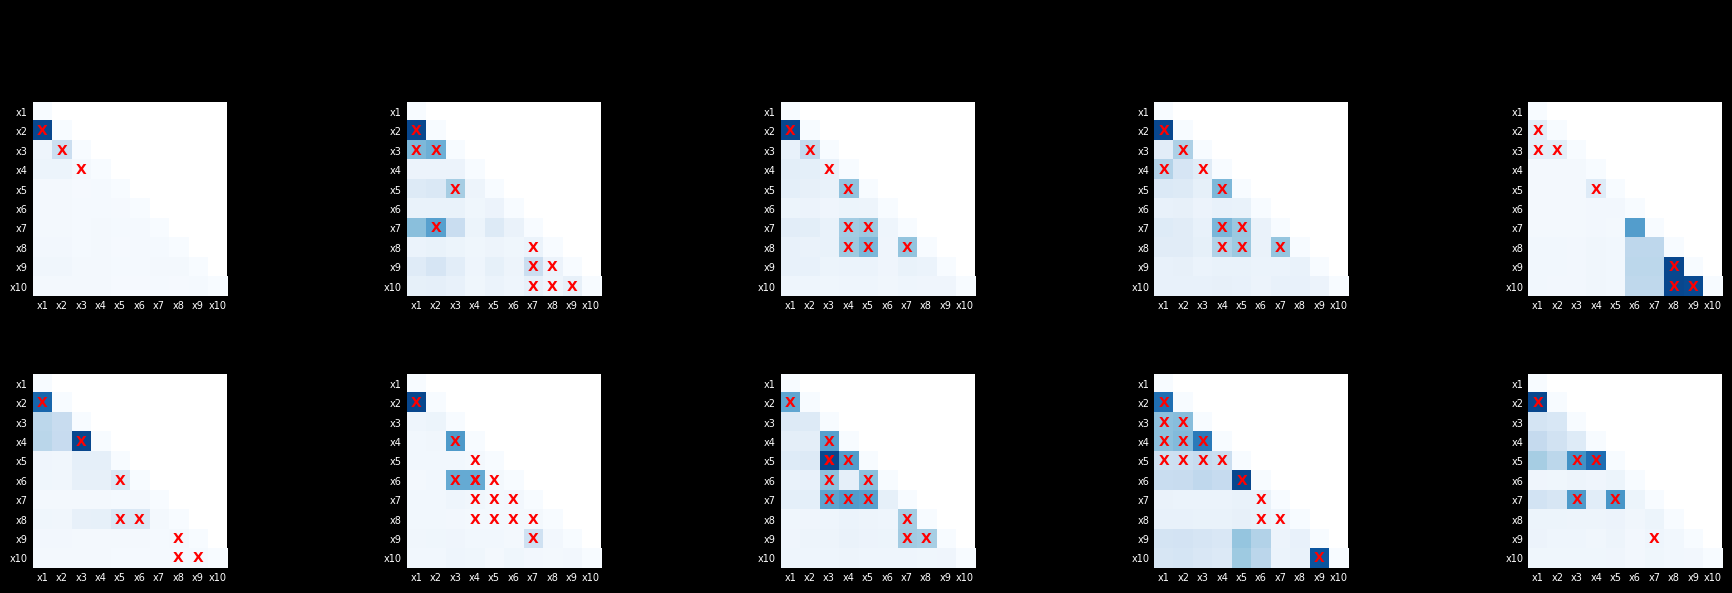

In [40]:
plot_heatmaps(results)

## Experiment 4

Want to comapre with other algos.

In [43]:
def run_anova(X_train, Y_train, ground_truth):
    n_features = X_train.shape[1]
    feature_cols = [f'X{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X_train, columns=feature_cols)
    df['Y'] = Y_train
    
    formula = 'Y ~ ' + ' + '.join(feature_cols) + ' + ' + \
              ' + '.join([f'X{i+1}:X{j+1}' for i in range(n_features) 
                          for j in range(i+1, n_features)])
    
    model = ols(formula, data=df).fit()
    anova_table = anova_lm(model, typ=2)
    
    interaction_scores = {}
    for term in anova_table.index:
        if ':' in term:
            i, j = sorted([int(f[1:])-1 for f in term.split(':')])
            interaction_scores[(i+1, j+1)] = anova_table.loc[term, 'F']
    
    sorted_interactions = sorted(interaction_scores.items(), key=lambda x: x[1], reverse=True)
    return get_pairwise_auc(sorted_interactions, ground_truth)

In [44]:
def run_hier_lasso(X_train, Y_train, ground_truth):
    # Generate polynomial features (degree 2, interaction only)
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X_train)
    
    # Fit LassoCV with cross-validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso = LassoCV(cv=5, max_iter=50000, random_state=42, n_jobs=1)
        lasso.fit(X_poly, Y_train.ravel())
    
    n_main = X_train.shape[1]
    interaction_coefs = lasso.coef_[n_main:]
    pairs = list(itertools.combinations(range(1, n_main + 1), 2))
    interactions = list(zip(pairs, np.abs(interaction_coefs)))
    
    return get_pairwise_auc(interactions, ground_truth)

In [45]:
num_samples = 30000
valid_size = 10000
test_size = 10000
device = torch.device("cuda")
hidden_layers = [140, 100, 60, 20]
l1_const = 5e-5
learning_rate = 1e-2

In [46]:
def run_all_methods_on_function(func, func_name):
    X = np.random.uniform(low=-1, high=1, size=(30000, 10))
    Y, ground_truth = func(X)
    
    data_loaders = preprocess_data(X, Y, 10000, 10000, True, True)
    
    model = MLP(num_features=10, hidden_units=[140, 100, 60, 20], use_main_effect_nets=True).to("cuda")
    model, _ = train(model, data_loaders, device="cuda", learning_rate=1e-2, l1_const=5e-5, verbose=False)
    weights = get_weights(model)
    pairwise = get_interactions(weights, pairwise=True, one_indexed=True)
    anyorder = get_interactions(weights, pairwise=False, one_indexed=True)
    auc = get_pairwise_auc(pairwise, ground_truth)
    r_prec = get_anyorder_R_precision(anyorder, ground_truth)
    
    model2 = MLP(num_features=10, hidden_units=[140, 100, 60, 20], use_main_effect_nets=False).to("cuda")
    model2, _ = train(model2, data_loaders, device="cuda", learning_rate=1e-2, l1_const=5e-5, verbose=False)
    weights2 = get_weights(model2)
    pairwise2 = get_interactions(weights2, pairwise=True, one_indexed=True)
    anyorder2 = get_interactions(weights2, pairwise=False, one_indexed=True)
    auc2 = get_pairwise_auc(pairwise2, ground_truth)
    r_prec2 = get_anyorder_R_precision(anyorder2, ground_truth)
    

    return {
        "ANOVA": run_anova(X, Y, ground_truth),
        "HierLasso": run_hier_lasso(X, Y, ground_truth),
        "NID(MLP)": auc2,
        "NID(MLP-M)": auc
    }

In [47]:
def main_experiment():
    from tqdm import tqdm
    results = {}
    functions = [("F1", F1), ("F2",F2), ("F3",F3), ("F4",F4), ("F5",F5), ("F6",F6), ("F7",F7), ("F8",F8),("F9",F9), ("F10", F10)] 
    for name, fn in tqdm(functions):
        print(f"\n=== {name} ===")
        res = run_all_methods_on_function(fn, name)
        results[name] = res
        print(res)
    df = pd.DataFrame(results).T
    df.loc["average"] = df.mean()
    print("\n=== Comparison Table ===")
    print(df.to_markdown(floatfmt=".3f"))


In [50]:
main_experiment()

  0%|          | 0/10 [00:00<?, ?it/s]


=== F1 ===


 10%|█         | 1/10 [00:56<08:26, 56.27s/it]

{'ANOVA': 0.626984126984127, 'HierLasso': 0.6349206349206349, 'NID(MLP)': 0.9841269841269841, 'NID(MLP-M)': 1.0}

=== F2 ===


 20%|██        | 2/10 [01:46<07:02, 52.77s/it]

{'ANOVA': 0.7112299465240641, 'HierLasso': 0.6951871657754011, 'NID(MLP)': 0.6844919786096256, 'NID(MLP-M)': 0.7433155080213903}

=== F3 ===


 30%|███       | 3/10 [02:23<05:18, 45.49s/it]

{'ANOVA': 0.8240740740740741, 'HierLasso': 0.5555555555555556, 'NID(MLP)': 0.9907407407407407, 'NID(MLP-M)': 0.9660493827160493}

=== F4 ===


 40%|████      | 4/10 [03:20<05:01, 50.17s/it]

{'ANOVA': 0.7, 'HierLasso': 0.6285714285714286, 'NID(MLP)': 1.0, 'NID(MLP-M)': 0.9914285714285714}

=== F5 ===


 50%|█████     | 5/10 [04:25<04:37, 55.48s/it]

{'ANOVA': 0.7669172932330827, 'HierLasso': 0.6729323308270677, 'NID(MLP)': 0.9022556390977444, 'NID(MLP-M)': 0.8947368421052632}

=== F6 ===


 60%|██████    | 6/10 [05:17<03:36, 54.14s/it]

{'ANOVA': 0.7432432432432433, 'HierLasso': 0.7297297297297297, 'NID(MLP)': 0.9391891891891891, 'NID(MLP-M)': 0.6486486486486487}

=== F7 ===


 70%|███████   | 7/10 [06:16<02:47, 55.97s/it]

{'ANOVA': 0.5737327188940092, 'HierLasso': 0.6497695852534562, 'NID(MLP)': 0.8133640552995391, 'NID(MLP-M)': 0.564516129032258}

=== F8 ===


 80%|████████  | 8/10 [06:59<01:43, 51.85s/it]

{'ANOVA': 0.9974747474747475, 'HierLasso': 0.9974747474747475, 'NID(MLP)': 1.0, 'NID(MLP-M)': 1.0}

=== F9 ===


 90%|█████████ | 9/10 [07:39<00:47, 47.99s/it]

{'ANOVA': 0.5933333333333333, 'HierLasso': 0.64, 'NID(MLP)': 0.8555555555555555, 'NID(MLP-M)': 0.6644444444444444}

=== F10 ===


100%|██████████| 10/10 [08:30<00:00, 51.08s/it]

{'ANOVA': 0.8461538461538461, 'HierLasso': 0.6367521367521368, 'NID(MLP)': 1.0, 'NID(MLP-M)': 0.9188034188034188}

=== Comparison Table ===
|         |   ANOVA |   HierLasso |   NID(MLP) |   NID(MLP-M) |
|:--------|--------:|------------:|-----------:|-------------:|
| F1      |   0.627 |       0.635 |      0.984 |        1.000 |
| F2      |   0.711 |       0.695 |      0.684 |        0.743 |
| F3      |   0.824 |       0.556 |      0.991 |        0.966 |
| F4      |   0.700 |       0.629 |      1.000 |        0.991 |
| F5      |   0.767 |       0.673 |      0.902 |        0.895 |
| F6      |   0.743 |       0.730 |      0.939 |        0.649 |
| F7      |   0.574 |       0.650 |      0.813 |        0.565 |
| F8      |   0.997 |       0.997 |      1.000 |        1.000 |
| F9      |   0.593 |       0.640 |      0.856 |        0.664 |
| F10     |   0.846 |       0.637 |      1.000 |        0.919 |
| average |   0.738 |       0.684 |      0.917 |        0.839 |


# Experiment 5

now will work on real dataset

In [80]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


In [81]:
data = fetch_california_housing()
X_full, y_full = data.data, data.target

print("Features shape:", X_full.shape) 
print("Labels shape:", y_full.shape)

Features shape: (20640, 8)
Labels shape: (20640,)


In [82]:
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1,1))

X_train_sc = scaler_x.transform(X_train)
X_val_sc   = scaler_x.transform(X_val)
X_test_sc  = scaler_x.transform(X_test)

y_train_sc = scaler_y.transform(y_train.reshape(-1,1))
y_val_sc   = scaler_y.transform(y_val.reshape(-1,1))
y_test_sc  = scaler_y.transform(y_test.reshape(-1,1))

In [83]:
def make_loader(X, y, batch_size=64, shuffle=False):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(tensor_x, tensor_y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

batch_size = 64
train_loader = make_loader(X_train_sc, y_train_sc, batch_size=batch_size, shuffle=True)
val_loader   = make_loader(X_val_sc,   y_val_sc,   batch_size=batch_size, shuffle=False)
test_loader  = make_loader(X_test_sc,  y_test_sc,  batch_size=batch_size, shuffle=False)

data_loaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
model = MLP(
    num_features=X_train_sc.shape[1],
    hidden_units=[64, 32],
    use_main_effect_nets=True  # or False
).to(device)

model, final_loss = train(
    net=model,
    data_loaders=data_loaders,
    nepochs=50,
    l1_const=1e-5,       # Adjust as needed
    learning_rate=1e-3,  # Adjust as needed
    verbose=True,
    device=device
)

print("Finished Training. Final loss:", final_loss)

starting to train
early stopping enabled
[epoch 1, total 50] train loss: 0.4459, val loss: 0.3535
[epoch 3, total 50] train loss: 0.2969, val loss: 0.3062
[epoch 5, total 50] train loss: 0.2528, val loss: 0.2612
[epoch 7, total 50] train loss: 0.2404, val loss: 0.2494
[epoch 9, total 50] train loss: 0.2282, val loss: 0.2443
[epoch 11, total 50] train loss: 0.2216, val loss: 0.2335
[epoch 13, total 50] train loss: 0.2190, val loss: 0.2337
[epoch 15, total 50] train loss: 0.2157, val loss: 0.2305
[epoch 17, total 50] train loss: 0.2111, val loss: 0.2256
[epoch 19, total 50] train loss: 0.2075, val loss: 0.2241
[epoch 21, total 50] train loss: 0.2087, val loss: 0.2224
[epoch 23, total 50] train loss: 0.2049, val loss: 0.2208
[epoch 25, total 50] train loss: 0.2053, val loss: 0.2233
[epoch 27, total 50] train loss: 0.2030, val loss: 0.2218
[epoch 29, total 50] train loss: 0.1994, val loss: 0.2188
[epoch 31, total 50] train loss: 0.1990, val loss: 0.2226
[epoch 33, total 50] train loss: 0.1

In [86]:
model_weights = get_weights(model)
pairwise_inters = get_interactions(model_weights, pairwise=True, one_indexed=False)
anyorder_inters = get_interactions(model_weights, pairwise=False, one_indexed=False)

print("Top 10 Pairwise Interactions (feature indices):")
for inter, strength in pairwise_inters[:10]:
    print(f"  {inter} -> {strength:.4f}")

Top 10 Pairwise Interactions (feature indices):
  (6, 7) -> 7.3314
  (5, 6) -> 6.6244
  (3, 6) -> 6.5678
  (3, 7) -> 6.1352
  (5, 7) -> 6.0817
  (2, 6) -> 5.9526
  (0, 6) -> 5.9002
  (2, 7) -> 5.7094
  (0, 7) -> 5.5117
  (0, 2) -> 5.3856


In [29]:
def plot_histogram(pairwise_inters, feature_names):
    n = len(feature_names)
    strength_matrix = np.zeros((n, n))
    
    for (i, j), strength in pairwise_inters:
        strength_matrix[i, j] = strength
        strength_matrix[j, i] = strength  
        
    mask = np.triu(np.ones_like(strength_matrix, dtype=bool))
    masked_matrix = np.ma.array(strength_matrix, mask=mask)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    cmap = plt.cm.Blues 
    cax = ax.imshow(masked_matrix, cmap=cmap, interpolation='none', origin='upper')
    
    cbar = fig.colorbar(cax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Interaction Strength", rotation=-90, va="bottom", fontsize=12)
    
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(feature_names, fontsize=10, rotation=45, color='black') 
    ax.set_yticklabels(feature_names, fontsize=10, color='black') 
    
    ax.set_xlabel("Features", fontsize=12, color='black')
    ax.set_ylabel("Features", fontsize=12, color='black')
    
    # Minor ticks for grid lines
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5) 
    ax.tick_params(which="minor", bottom=False, left=False)
    
    for i in range(n):
        for j in range(n):
            if i > j: 
                value = strength_matrix[i, j]
                if value != 0:
                    ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                            color="black", fontsize=9, fontweight="bold")
    
    # Set title and background colors
    ax.set_title("Pairwise Interaction Strengths (Housing Dataset)", fontsize=14, color="black")
    ax.set_facecolor("white") 
    fig.patch.set_facecolor("white")  
    
    # Display the plot
    plt.tight_layout()
    plt.show()

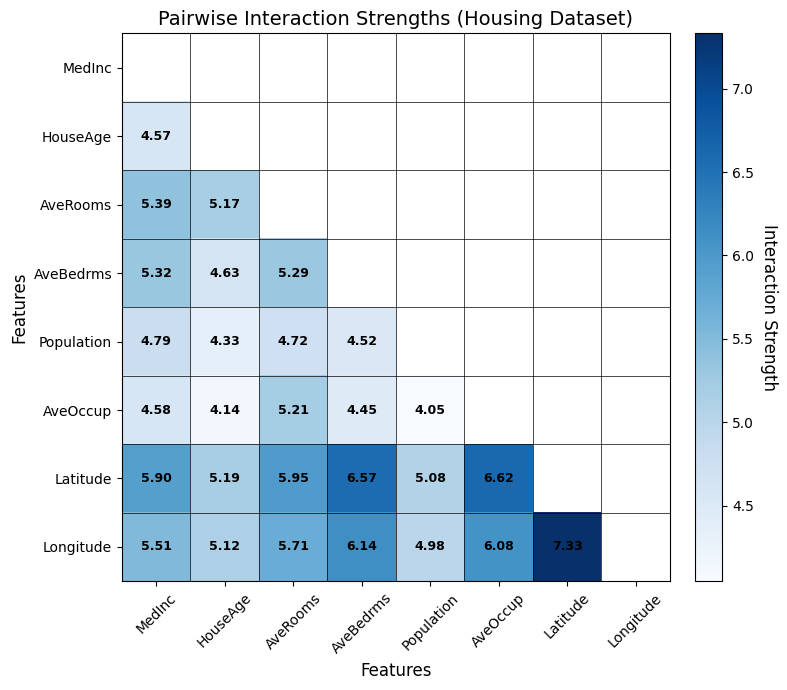

In [88]:
feature_names = [
    "MedInc", "HouseAge", "AveRooms", "AveBedrms", 
    "Population", "AveOccup", "Latitude", "Longitude"
]
plot_histogram(pairwise_inters, feature_names)

# Experiment 6

now will train on letter dataset

In [19]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
column_names = [
    'target', 'x-box', 'y-box', 'width', 'height', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar',
    'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx'
]
data = pd.read_csv(url, header=None, names=column_names)

# Display the first few rows
data.head()

,target,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [20]:
X = data.drop(['target'], axis=1).values
Y = data['target'].values

In [21]:
num_features = 16

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y) 
print(label_encoder.classes_)  

[19  8  3 ... 19 18  0]
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [23]:
data_loaders = preprocess_data(X, Y, valid_size=3300, test_size=3200, std_scale=True, get_torch_loaders=True)

In [24]:
device = torch.device("cuda")
model = MLP(num_features, [140, 100, 60, 20], use_main_effect_nets=True).to(device)
model, mlp_loss = train(model, data_loaders, device=device, learning_rate=1e-2, l1_const = 5e-5, verbose=True)
model_weights = get_weights(model)
anyorder_interactions = get_interactions(model_weights, one_indexed=True)
pairwise_interactions = get_interactions(model_weights, pairwise=True, one_indexed=False)

starting to train
early stopping enabled
[epoch 1, total 100] train loss: 0.4586, val loss: 0.2897
[epoch 3, total 100] train loss: 0.2130, val loss: 0.2165
[epoch 5, total 100] train loss: 0.1677, val loss: 0.1983
[epoch 7, total 100] train loss: 0.1337, val loss: 0.1642
[epoch 9, total 100] train loss: 0.1289, val loss: 0.1198
[epoch 11, total 100] train loss: 0.1058, val loss: 0.1288
[epoch 13, total 100] train loss: 0.0995, val loss: 0.1142
[epoch 15, total 100] train loss: 0.0914, val loss: 0.1201
[epoch 17, total 100] train loss: 0.0827, val loss: 0.1011
[epoch 19, total 100] train loss: 0.0856, val loss: 0.1168
[epoch 21, total 100] train loss: 0.0876, val loss: 0.1041
[epoch 23, total 100] train loss: 0.0724, val loss: 0.1009
[epoch 25, total 100] train loss: 0.0724, val loss: 0.1157
[epoch 27, total 100] train loss: 0.0828, val loss: 0.1093
[epoch 29, total 100] train loss: 0.0673, val loss: 0.1026
early stopping!
Finished Training. Test loss:  0.11076465249061584


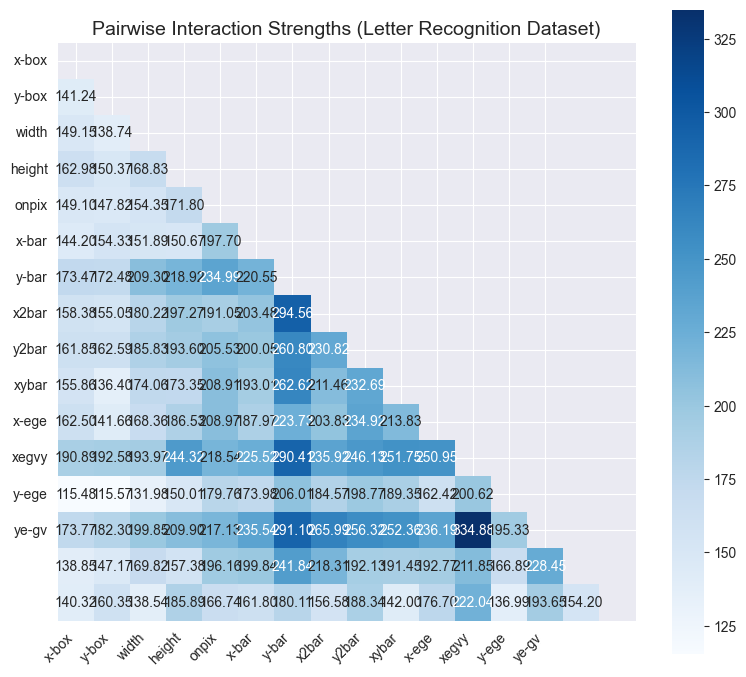

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

num_features = 16
feature_names = [
    'x-box', 'y-box', 'width', 'height', 'onpix', 
    'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 
    'x-ege', 'xegvy', 'y-ege', 'ye-gv', 'class'
]

feature_names = feature_names[:-1]

interaction_matrix = np.zeros((num_features, num_features))

# Add the values for interaction strengths from the pairwise interactions
for (i, j), strength in pairwise_interactions:
    i_idx, j_idx = i - 1, j - 1
    interaction_matrix[i_idx, j_idx] = strength
    interaction_matrix[j_idx, i_idx] = strength

mask = np.triu(np.ones_like(interaction_matrix, dtype=bool))

# Create the heatmap with annotation (values displayed in each cell)
plt.figure(figsize=(8, 7))

sns.heatmap(
    interaction_matrix,
    mask=mask,
    cmap="Blues",
    xticklabels=feature_names,
    yticklabels=feature_names,
    square=True,
    annot=True,   # Display values in the cells
    cbar=True,
    fmt=".2f"    # Format the values to display two decimal places
)

plt.title("Pairwise Interaction Strengths (Letter Recognition Dataset)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

# Experiemnt 7 for Multicollinearity Experiment

We work on multicollinearity experiment from here

In [32]:
def create_cloned_dataset(n_clones, num_samples=30000):
    X_base = np.random.normal(loc=0, scale=1, size=(num_samples, 2))
    X1 = X_base[:, 0].reshape(-1, 1)
    X2 = X_base[:, 1].reshape(-1, 1)

    X1_clones = np.tile(X1, (1, n_clones))
    X = np.hstack([X1_clones, X2])

    Y = (X1 * X2).ravel()
    ground_truth = [ {i+1, n_clones+1} for i in range(n_clones) ]

    return X, Y, ground_truth

In [33]:
from tqdm import tqdm
def run_multicollinearity_experiment(clone_list, use_main_effect_nets=True):
    auc_results = []
    strength_results = []

    for n_clones in tqdm(clone_list, desc="Exact Clone Experiments"):
        X, Y, ground_truth = create_cloned_dataset(n_clones, num_samples=30000)

        data_loaders = preprocess_data(
            X, Y,
            valid_size=10000,
            test_size=10000,
            std_scale=True,
            get_torch_loaders=True
        )

        model = MLP(num_features=X.shape[1], hidden_units=[64, 32],
                    use_main_effect_nets=use_main_effect_nets).to(device)
        model, _ = train(
            model, data_loaders,
            device=device,
            learning_rate=1e-2,
            l1_const=5e-5,
            verbose=False
        )

        w = get_weights(model)
        pairwise = get_interactions(w, pairwise=True, one_indexed=True)

        auc = get_pairwise_auc(pairwise, ground_truth)
        auc_results.append((n_clones, auc))

        clone_strengths = [ strength for ((i, j), strength) in pairwise
                            if ( (i in range(1, n_clones+1) and j == n_clones+1) or
                                 (j in range(1, n_clones+1) and i == n_clones+1) ) ]
        strength_results.append((n_clones, clone_strengths))

    return auc_results, strength_results

In [34]:
def plot_multicollinearity_results(auc_results, strength_results):
    clone_values, auc_values = zip(*auc_results)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    ax1 = axes[0]
    ax1.plot(clone_values, auc_values, marker='o', linestyle='-', color='dodgerblue', linewidth=2)
    ax1.set_title("Pairwise AUC vs. Number of Clones", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Number of X1 Clones", fontsize=12)
    ax1.set_ylabel("Pairwise AUC", fontsize=12)
    ax1.grid(True, linestyle="--", alpha=0.7)

    ax2 = axes[1]
    strength_data = [s for _, s in strength_results]
    box = ax2.boxplot(strength_data, patch_artist=True,
                      labels=[str(n) for n in clone_values],
                      medianprops=dict(color='red', linewidth=2),
                      boxprops=dict(facecolor='lightblue', color='blue'),
                      whiskerprops=dict(color='blue', linewidth=1.5),
                      capprops=dict(color='blue', linewidth=1.5))
    ax2.set_title("Interaction Strength Distribution vs. Number of Clones", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Number of X1 Clones", fontsize=12)
    ax2.set_ylabel("Interaction Strength", fontsize=12)
    ax2.grid(True, linestyle="--", alpha=0.7)

    plt.suptitle("Multicollinearity Effects on Interaction Detection", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Exact Clone Experiments: 100%|██████████| 7/7 [10:34<00:00, 90.67s/it] 


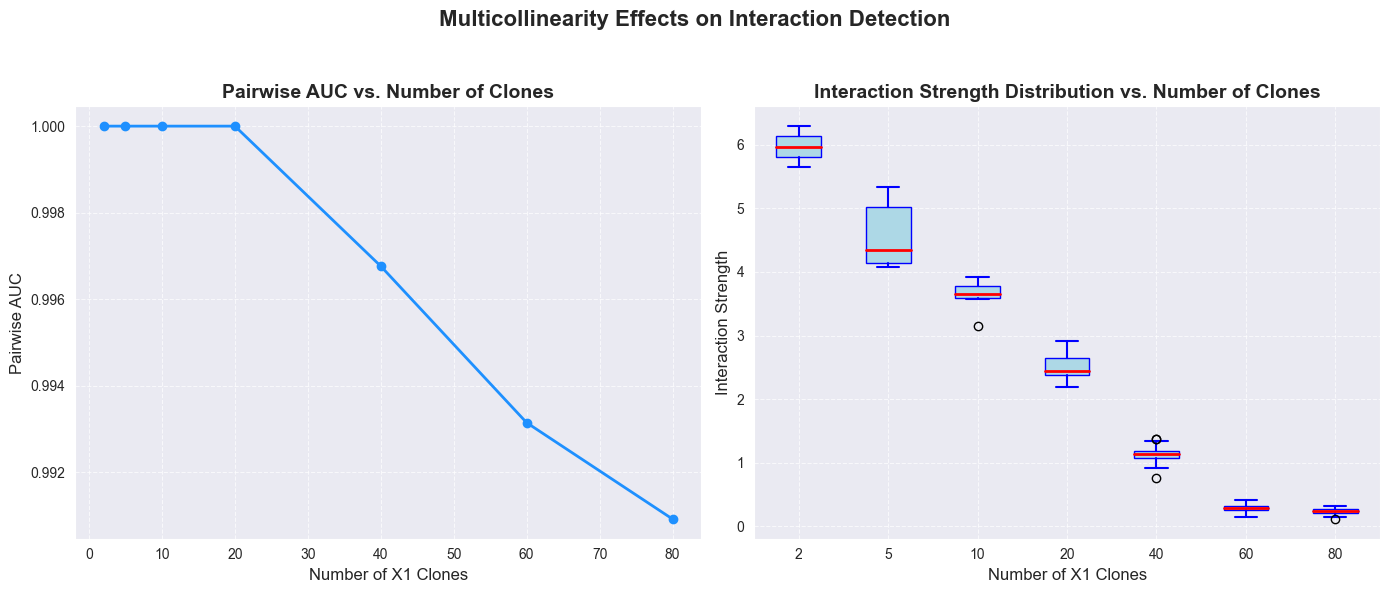

In [36]:
clone_list = [2, 5, 10, 20, 40, 60, 80]
auc_results, strength_results = run_multicollinearity_experiment(clone_list)
plot_multicollinearity_results(auc_results, strength_results)

# Experiemnt 8 for Multicollinearity Experiment

In [14]:
def create_correlated_dataset(sigma, num_samples=30000):
    X1 = np.random.normal(loc=0, scale=1, size=num_samples)
    X2 = np.random.normal(loc=0, scale=1, size=num_samples)
    noise = np.random.normal(loc=0, scale=sigma, size=num_samples)
    X1_prime = X1 + noise
    
    X = np.stack([X1, X2, X1_prime], axis=1)
    Y = X1 * X2  # true interaction is X1 * X2
    
    # Ground truth in 1-indexed notation: {1, 2} => (X1, X2)
    ground_truth = [{1, 2}]
    return X, Y, ground_truth

In [38]:
def run_correlated_experiment(sigmas, num_samples=30000):
    correlation_list = []
    auc_list = []
    strength_X1X2 = []
    strength_X1primeX2 = []

    for sigma in tqdm(sigmas, desc="Correlated Features"):
        X, Y, gt = create_correlated_dataset(sigma, num_samples)
        corr = np.corrcoef(X[:,0], X[:,2])[0, 1]
        correlation_list.append(corr)
        
        data_loaders = preprocess_data(
            X, Y,
            valid_size=1000,
            test_size=1000,
            std_scale=True,
            get_torch_loaders=True
        )

        model = MLP(num_features=X.shape[1], hidden_units=[64, 32],
                    use_main_effect_nets=True).to(device)
        model, _ = train(
            model, data_loaders,
            device=device,
            learning_rate=1e-2,
            l1_const=5e-5,
            verbose=False
        )

        w = get_weights(model)
        pairwise_inters = get_interactions(w, pairwise=True, one_indexed=True)
        
        auc = get_pairwise_auc(pairwise_inters, gt)
        auc_list.append(auc)
        
        s_X1X2 = 0.0
        s_X1primeX2 = 0.0
        for (i, j), strength in pairwise_inters:
            pair = tuple(sorted((i, j)))
            if pair == (1, 2):
                s_X1X2 = strength
            elif pair == (2, 3) or pair == (3, 2):
                s_X1primeX2 = strength
        strength_X1X2.append(s_X1X2)
        strength_X1primeX2.append(s_X1primeX2)

    return correlation_list, auc_list, strength_X1X2, strength_X1primeX2


In [39]:
import seaborn as sns
def plot_correlation_experiment(correlation_list, auc_list, strength_X1X2, strength_X1primeX2):
    sns.set_style("whitegrid")

    fig, ax1 = plt.subplots(figsize=(10, 6))
    color_auc = 'tab:blue'
    ax1.set_xlabel("Correlation between X1 and X1'", fontsize=12)
    ax1.set_ylabel("Pairwise AUC", color=color_auc, fontsize=12)
    line_auc = ax1.plot(
        correlation_list, auc_list, 
        marker='o', color=color_auc, linewidth=2,
        label="AUC"
    )
    ax1.tick_params(axis='y', labelcolor=color_auc)
    ax1.set_ylim(0, 1.05)  # Ensure top margin
    ax1.set_title(
        "Impact of Correlation on AUC & Interaction Strengths",
        fontsize=14, fontweight='bold'
    )
    ax2 = ax1.twinx() 
    color_strength = 'tab:green'
    ax2.set_ylabel("Interaction Strength", color=color_strength, fontsize=12)
    line_x1x2 = ax2.plot(
        correlation_list, strength_X1X2, 
        marker='s', color='green', linewidth=2,
        label="Strength(X1,X2)"
    )
    line_x1p_x2 = ax2.plot(
        correlation_list, strength_X1primeX2, 
        marker='^', color='red', linewidth=2,
        label="Strength(X1',X2)"
    )
    ax2.tick_params(axis='y', labelcolor=color_strength)
    lines = line_auc + line_x1x2 + line_x1p_x2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center', fontsize=10, ncol=3)

    plt.tight_layout()
    plt.show()

Correlated Features: 100%|██████████| 6/6 [03:21<00:00, 33.64s/it]


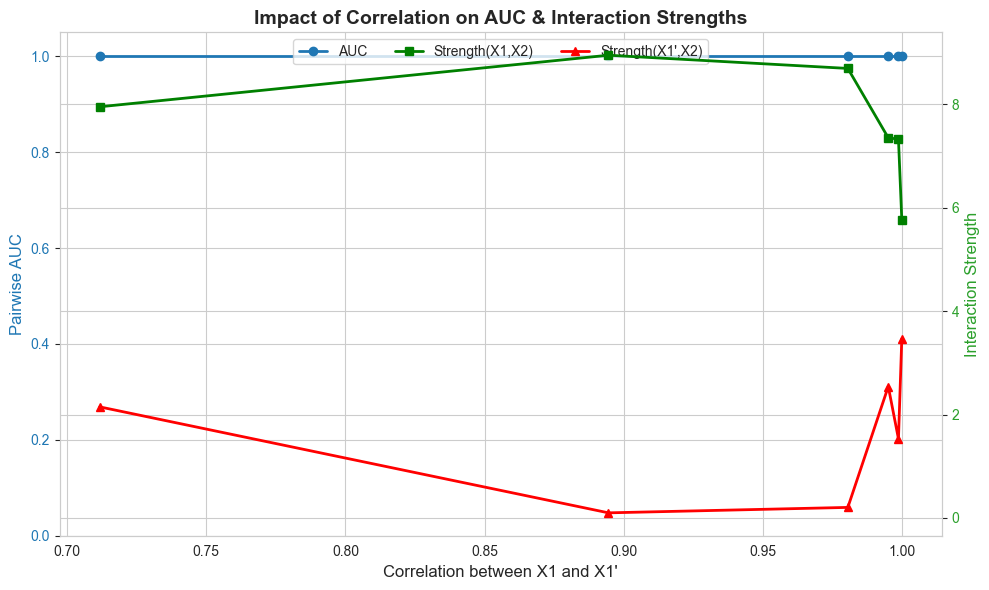

In [40]:
sigmas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
correlation_list, auc_list, sX1X2, sX1pX2 = run_correlated_experiment(sigmas)
plot_correlation_experiment(correlation_list, auc_list, sX1X2, sX1pX2)

# Experiemnt 9 for Multicollinearity Experiment

In [41]:
def create_cloned_dataset(n_clones, num_samples=30000):
    X_base = np.random.normal(loc=0, scale=1, size=(num_samples, 2))
    X1 = X_base[:, 0].reshape(-1, 1)
    X2 = X_base[:, 1].reshape(-1, 1)

    X1_clones = np.tile(X1, (1, n_clones))
    X = np.hstack([X1_clones, X2])

    Y =  np.prod(X, axis=1)
    ground_truth = [ {i+1, n_clones+1} for i in range(n_clones) ]

    return X, Y, ground_truth

Exact Clone Experiments: 100%|██████████| 7/7 [05:47<00:00, 49.58s/it]


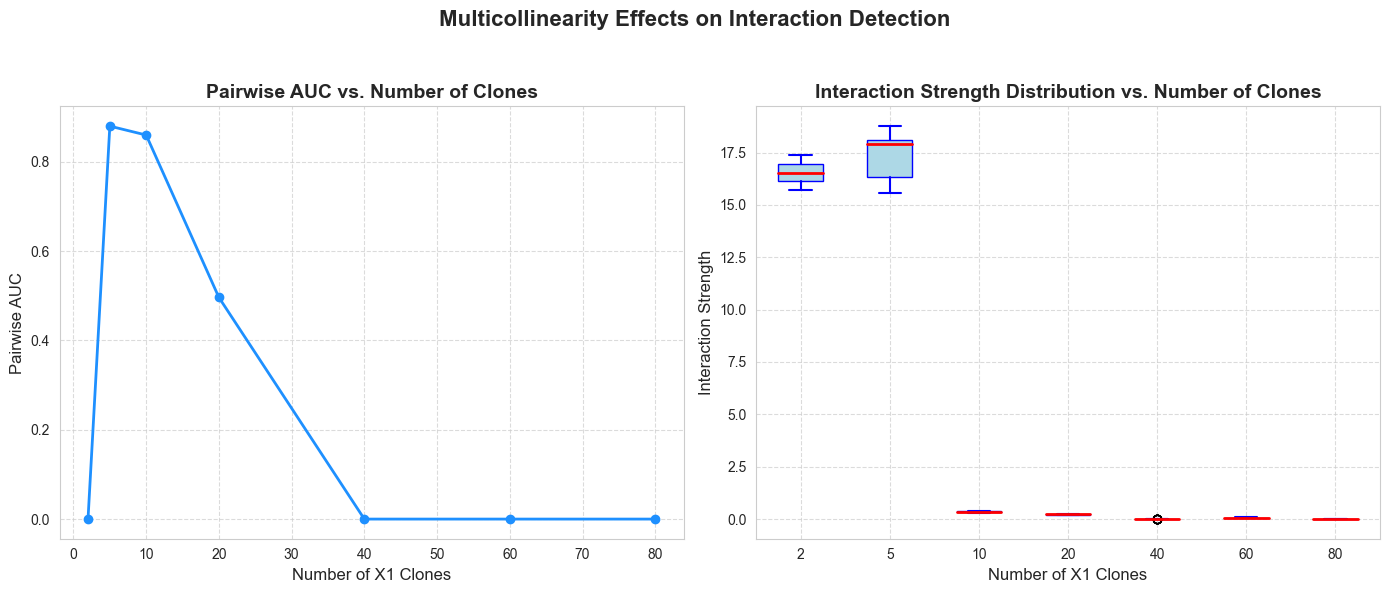

In [42]:
clone_list = [2, 5, 10, 20, 40, 60, 80]
auc_results, strength_results = run_multicollinearity_experiment(clone_list)
plot_multicollinearity_results(auc_results, strength_results)

# Experiement 10 

Propose a way how to estimate the power of interaction.

In [6]:
def permutation_test_interactions(
    X, Y, interactions, num_permutations=10, significance_level=0.05, device=torch.device("cuda")
):
    set_seed(42)
    _, p = X.shape
    permuted_strengths = {inter: [] for inter, _ in interactions}

    for perm in trange(num_permutations, desc="Permutation Test"):
        Y_perm = shuffle(Y)
        loaders_perm = preprocess_data(
            X, Y_perm, valid_size=100, test_size=100, std_scale=True, get_torch_loaders=True, batch_size=256
        )

        model_perm = MLP(p, [64, 32]).to(device)
        model_perm, _ = train(
            model_perm, loaders_perm, device=device, learning_rate=1e-2, l1_const=1e-5, nepochs=10, patience=2
        )

        weights_perm = get_weights(model_perm)
        perm_interactions = get_interactions(weights_perm, one_indexed=True)

        for inter, strength in perm_interactions:
            if inter in permuted_strengths:
                permuted_strengths[inter].append(strength)

    significant_interactions = []
    epsilon = 1e-8  

    for inter, strength in interactions:
        null_distribution = permuted_strengths.get(inter, [])
        if len(null_distribution) == 0:
            threshold = np.inf  # no chance to pass significance
        else:
            threshold = np.percentile(null_distribution, 100 * (1 - significance_level)) + epsilon
        if strength > threshold:
            significant_interactions.append((inter, strength))

    return significant_interactions

def enhanced_nid(X, Y, device=torch.device("cuda")):
    set_seed(42)
    loaders = preprocess_data(
        X, Y, valid_size=1000, test_size=1000, std_scale=True, get_torch_loaders=True, batch_size=256
    )

    model = MLP(X.shape[1], [64, 32]).to(device)
    model, _ = train(model, loaders, device=device, learning_rate=1e-2, l1_const=1e-5, nepochs=20, patience=3)

    weights = get_weights(model)
    anyorder_interactions = get_interactions(weights, one_indexed=True)
    pairwise_interactions = get_interactions(weights, pairwise=True, one_indexed=True)

    significant_interactions = permutation_test_interactions(X, Y, pairwise_interactions, device=device, num_permutations=5)

    return significant_interactions, model

In [7]:
def synth_func(X):
    X1, X2, X3, X4, X5, X6, X7, X8, X9, X10 = X.transpose()

    interaction1 = np.exp(np.abs(X1-X2))                        
    interaction2 = np.abs(X2*X3)  
    interaction3 = -1*(X3**2)**np.abs(X4) 
    interaction4 = (X1*X4)**2
    interaction5 = np.log(X4**2 + X5**2 + X7**2 + X8**2)
    main_effects = X9 + 1/(1 + X10**2)

    Y =              interaction1 + interaction2 + interaction3 + interaction4 + interaction5 + main_effects
    ground_truth = [     {1,2},        {2,3},         {3,4},         {1,4},        {4,5,7,8}     ]
    
    return Y, ground_truth

In [8]:
set_seed(42)
num_samples = 30000
num_features = 10

X = np.random.uniform(low=-1, high=1, size=(num_samples,num_features))
Y, ground_truth = synth_func(X)

# Run the NID and print significant interactions
significant_interactions, model = enhanced_nid(X, Y)

print("Significant Interactions (after permutation test):")
for inter, strength in significant_interactions[:10]:
    print(f"Interaction: {inter}, Strength: {strength:.4f}")

Permutation Test: 100%|██████████| 5/5 [00:35<00:00,  7.20s/it]

Significant Interactions (after permutation test):
Interaction: (7, 8), Strength: 2.9624
Interaction: (1, 4), Strength: 2.7962
Interaction: (2, 4), Strength: 2.7719
Interaction: (1, 7), Strength: 1.9591
Interaction: (2, 5), Strength: 1.8280
Interaction: (3, 4), Strength: 1.4167
Interaction: (9, 10), Strength: 1.4073
Interaction: (1, 3), Strength: 1.1530
Interaction: (3, 10), Strength: 1.0534
Interaction: (4, 10), Strength: 1.0345


In [9]:
auc = get_pairwise_auc(significant_interactions, ground_truth)

In [10]:
auc

0.9375

We get high auc which means our algo is working. Now we want to check if our algo perform better in correlated experiemnt

In [15]:
def run_correlated_experiment(sigmas, num_samples=30000):
    correlation_list = []
    auc_list = []
    strength_X1X2 = []
    strength_X1primeX2 = []

    for sigma in tqdm(sigmas, desc="Correlated Features"):
        X, Y, gt = create_correlated_dataset(sigma, num_samples)
        corr = np.corrcoef(X[:, 0], X[:, 2])[0, 1]
        correlation_list.append(corr)
        
        data_loaders = preprocess_data(
            X, Y,
            valid_size=1000,
            test_size=1000,
            std_scale=True,
            get_torch_loaders=True
        )

        significant_interactions, model = enhanced_nid(X, Y)

        w = get_weights(model)
        pairwise_inters = get_interactions(w, pairwise=True, one_indexed=True)
        
        auc = get_pairwise_auc(pairwise_inters, gt)
        auc_list.append(auc)
        
        s_X1X2 = 0.0
        s_X1primeX2 = 0.0
        for (i, j), strength in pairwise_inters:
            pair = tuple(sorted((i, j)))
            if pair == (1, 2):
                s_X1X2 = strength
            elif pair == (2, 3) or pair == (3, 2):
                s_X1primeX2 = strength
        strength_X1X2.append(s_X1X2)
        strength_X1primeX2.append(s_X1primeX2)

    return correlation_list, auc_list, strength_X1X2, strength_X1primeX2

In [16]:
from tqdm import tqdm
sigmas = [0.1,0.3, 0.5, 1.0] 
correlation_list, auc_list, strength_X1X2, strength_X1primeX2 = run_correlated_experiment(sigmas)

Correlated Features: 100%|██████████| 4/4 [03:07<00:00, 46.79s/it]


In [17]:
def plot_correlated_experiment_results(correlation_list, auc_list, strength_X1X2, strength_X1primeX2, sigmas):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    ax1 = axes[0]

    ax1.plot(sigmas, correlation_list, marker='o', linestyle='-', color='dodgerblue', linewidth=2)
    ax1.set_title("Correlation between X1 and X1' vs Sigma", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Sigma (Correlation Level)", fontsize=12)
    ax1.set_ylabel("Correlation (X1, X1')", fontsize=12)
    ax1.grid(True, linestyle="--", alpha=0.7)

    ax2 = axes[1]
    ax2.plot(sigmas, auc_list, marker='o', linestyle='-', color='darkorange', linewidth=2)
    ax2.set_title("Pairwise AUC vs Sigma", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Sigma (Correlation Level)", fontsize=12)
    ax2.set_ylabel("Pairwise AUC", fontsize=12)
    ax2.grid(True, linestyle="--", alpha=0.7)


    ax3 = axes[2]
    ax3.plot(sigmas, strength_X1X2, marker='o', linestyle='-', color='green', label='X1-X2', linewidth=2)
    ax3.plot(sigmas, strength_X1primeX2, marker='o', linestyle='-', color='red', label="X1'-X2", linewidth=2)
    ax3.set_title("Interaction Strength vs Sigma", fontsize=14, fontweight="bold")
    ax3.set_xlabel("Sigma (Correlation Level)", fontsize=12)
    ax3.set_ylabel("Interaction Strength", fontsize=12)
    ax3.grid(True, linestyle="--", alpha=0.7)
    ax3.legend()

    plt.tight_layout()
    plt.suptitle("Correlated Features Experiment Results", fontsize=16, fontweight="bold", y=1.05)
    plt.show()

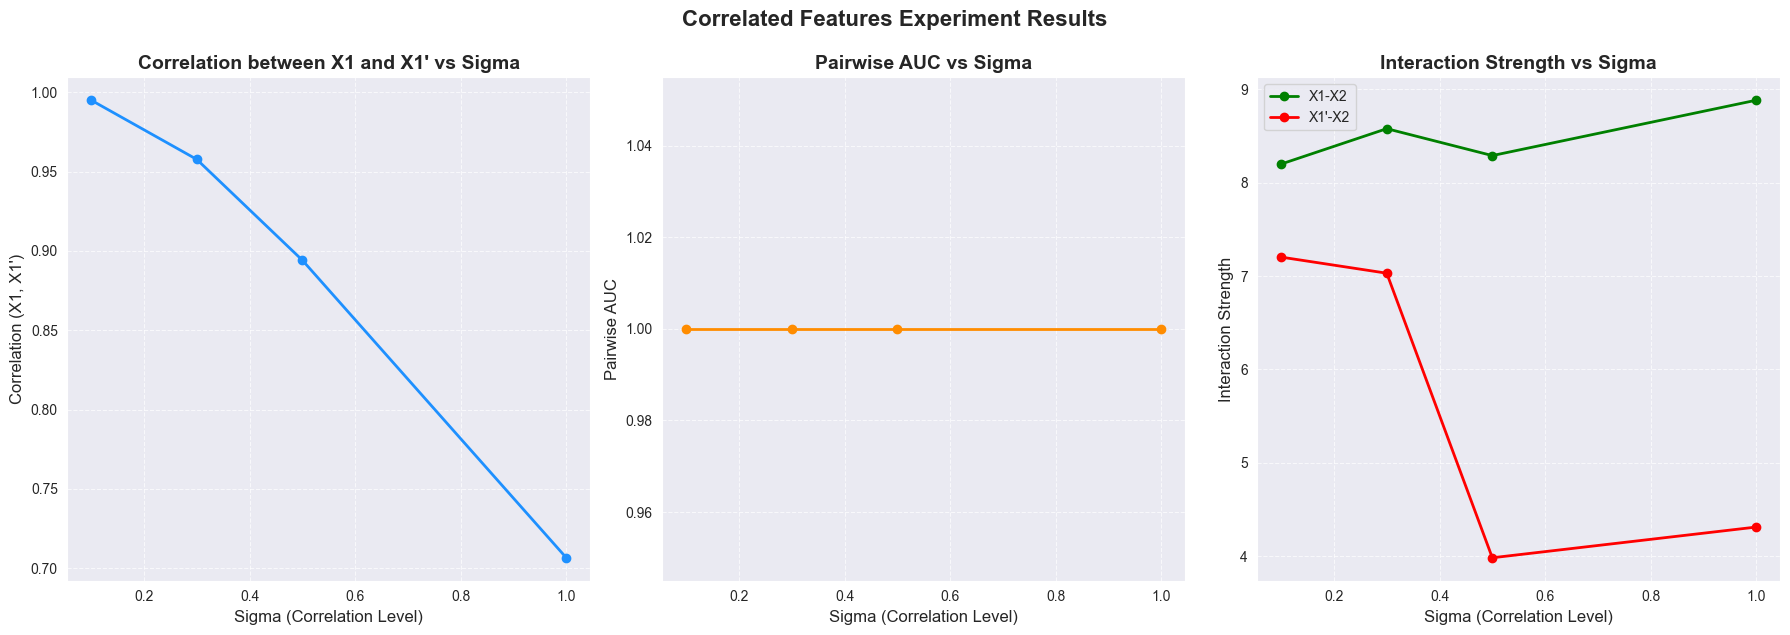

In [18]:
plot_correlated_experiment_results(correlation_list, auc_list, strength_X1X2, strength_X1primeX2, sigmas)